# Analisando o grafo

## Imports

In [1]:
import netpixi
from netpixi.integration.gt import Graph
from netpixi.integration.gt import *

from regression.integration.gt import *

import seaborn as sns

import cpnet

from graph_tool import spectral
from graph_tool import clustering

import numpy as np

import pandas as pd

import regression as reg

from scipy import stats

from matplotlib import pyplot as plt

import gzip

import json

<frozen importlib._bootstrap>:914: ImportWarning: VendorImporter.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: VendorImporter.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: VendorImporter.find_spec() not found; falling back to find_module()


## Compilando e renderizando o grafo

In [2]:
g = gt_load('git_hub_sfdp.net.gz')
r = netpixi.render('git_hub_sfdp.net.gz')

## Melhorando visualmento o grafo

In [3]:
# mudar a cor de fundo do grafo
r.graph(color=0xffffff)

# mudar a cor e o tamanho dos vértices
r.vertex_default(color=0x000000, size=10)

# mudar a cor, a espessura e a curvatura das arestas
r.edge_default(color=0x000000, width=1, curve1=1, curve2=1)

## Análise exploratória do grafo

In [4]:
# Números de vértices
n = g.num_vertices()

# Número de arestas
m = g.num_edges()

# Número máximo possível de arestas
if g.is_directed():
    max_edges = n * (n - 1)
else:
    max_edges = n * (n - 1) // 2
    
# Densidade
d = m / max_edges


print(f"""Números de vértices: {n}

Número de arestas: {m}

Número máximo possível de arestas: {max_edges}

Densidade: {d}""")

Números de vértices: 893

Número de arestas: 31953

Número máximo possível de arestas: 398278

Densidade: 0.08022788102782479


count    893.000000
mean      71.563270
std       77.695938
min        1.000000
25%       12.000000
50%       40.000000
75%      107.000000
max      329.000000
Name: degree, dtype: float64

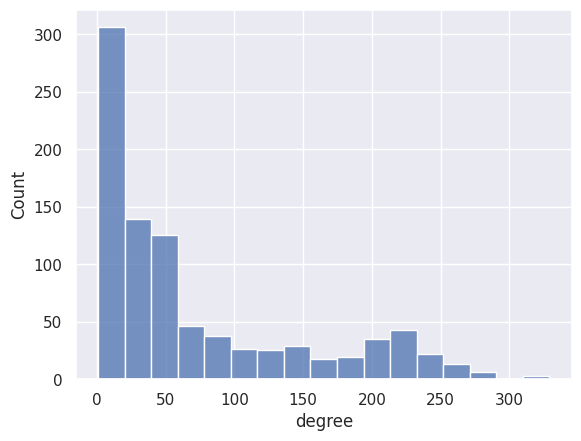

In [5]:
# Propriedades de cada vértice
data = gt_data(g)

# Degree
degrees = []
for v in g.all_vertices():
    degrees.append(v.total_degree())
    
data['degree'] = degrees

# Histograma do degree
sns.histplot(data['degree']);
data['degree'].describe()

## Análise das variáveis dependentes e independentes

### Criando um novo dataset

In [6]:
# Dataset refatorado
data_refatorado = pd.read_csv('Github_data_refatorado.csv')

# Dataset do grafo
data_grafo = data_refatorado.copy()

<frozen importlib._bootstrap>:914: ImportWarning: VendorImporter.find_spec() not found; falling back to find_module()


### Coletando os dados

In [7]:
# Coletando o clustering coefficient de cada vértice

lc = clustering.local_clustering(g)

clustering = [] # Lista de clustering coefficient de cada vértice
for value in lc:
    clustering.append(value)

In [8]:
# Coletando o nome dos vértices do grafo

nome_arquivo_comprimido = 'git_hub_sfdp.net.gz'
nome_arquivo_descompactado = [] # Lista dos nomes dos vértices do grafo

try:
    with gzip.open(nome_arquivo_comprimido, 'r') as arquivo_comprimido:
        arquivo_comprimido.readline()
        for linha in arquivo_comprimido:
            objeto = json.loads(linha.decode('utf-8'))
            nome_arquivo_descompactado.append(objeto['props']['_id'])
except:
    print("Nome dos vértices coletados")

Nome dos vértices coletados


### Alterando o dataset

In [9]:
# Filtrando o dataset para somente as os vértices do grafo
data_grafo = data_grafo.loc[data_grafo['name'].isin(nome_arquivo_descompactado)]

# Colocando log nos commits
data_grafo['commits'] = np.log(data_grafo['commits'])

# Colocando log nas stars
data_grafo['star'] = np.log(data_grafo['star'])

# Adicionando clustering coefficient (CC) na tabela
data_grafo['CC'] = clustering

# Adicionando degrees na tabela
data_grafo['degree'] = degrees

# Adicionando pertencimento a comunidade (PC) na tabela
data_grafo['PC'] = data_grafo['degree'] * data_grafo['CC']

In [10]:
data_grafo.loc[:, ['name', 'star', 'topic_tag', 'commits', 'CC', 'degree', 'PC']]

,name,star,topic_tag,commits,CC,degree,PC
0,keras,10.776871,"['deep-learning', 'tensorflow', 'neural-networ...",8.583355,0.658662,239,157.420168
1,scikit-learn,10.604107,"['machine-learning', 'python', 'statistics', '...",10.142701,0.828093,133,110.136364
2,PythonDataScienceHandbook,10.047588,"['scikit-learn', 'numpy', 'python', 'jupyter-n...",5.455321,0.943182,33,31.125000
3,Probabilistic-Programming-and-Bayesian-Methods...,9.952278,"['bayesian-methods', 'pymc', 'mathematical-ana...",6.983790,0.955026,28,26.740741
5,data-science-ipython-notebooks,9.814656,"['python', 'machine-learning', 'deep-learning'...",6.297109,0.607090,247,149.951220
...,...,...,...,...,...,...,...
1475,Adafruit-Fingerprint-Sensor-Library,5.468060,"['arduino', 'sensor', 'library', 'fingerprint']",4.290459,0.833333,4,3.333333
1481,VeloView,5.384495,"['lidar', 'lidar-camera-calibration', 'lidar-d...",7.410347,0.000000,1,0.000000
1491,NaveGo,5.318120,"['navigation', 'inertial-sensors', 'allan-vari...",5.749393,1.000000,2,2.000000
1492,home-assistant-config,5.318120,"['home-assistant', 'home-assistant-config', 'h...",5.455321,0.333333,10,3.333333


### Resultados

In [11]:
result = reg.linear(data=data_grafo, formula='commits ~ PC + star')

In [12]:
result.micro_summary()

variable,coefficient,std error,p-value
PC,-0.002360,0.000996,0.018051
star,0.718105,0.029074,0.000000


In [13]:
result.nano_summary()

-0.002 (0.001) **
+0.718 (0.029) ***


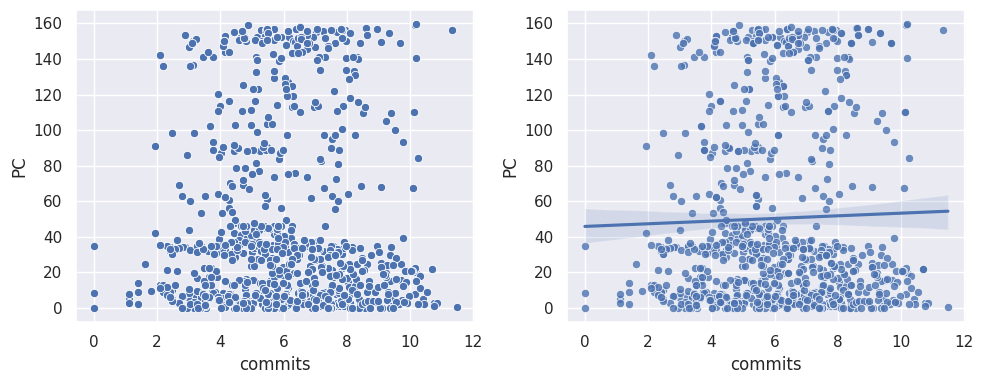

In [14]:
# Plotando os gráficos de distribuição linear

# Criando subplot
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plotando os gráficos
sns.scatterplot(x=data_grafo["commits"], y=data_grafo["PC"], # Dados
                edgecolor='white', linewidth=0.6, # Personalizando
                ax=axes[0]); # Subplot

sns.regplot(x=data_grafo["commits"], y=data_grafo["PC"], # Dados
            scatter_kws={"edgecolor": "white", "linewidth": 0.6}, # Personalizando
            ax=axes[1]); # Subplot

plt.tight_layout()
plt.show()

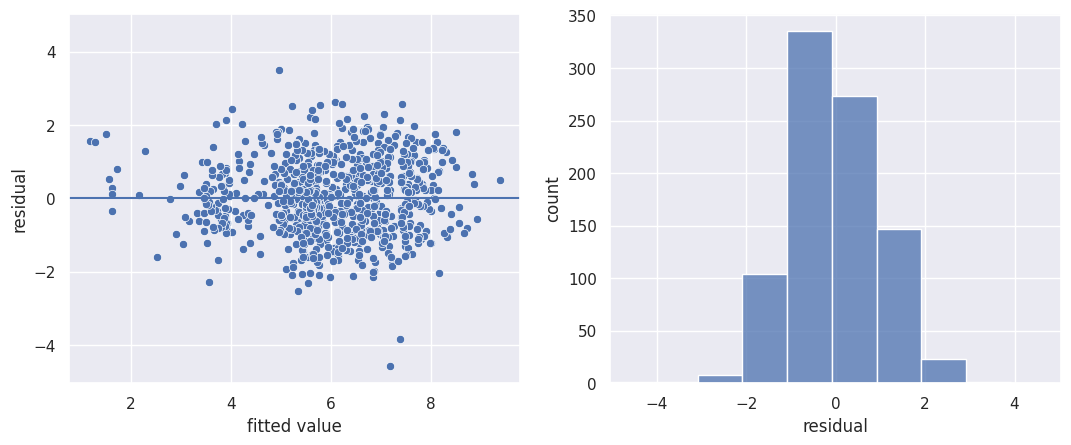

In [15]:
# Plotando o gráfico de resíduos
result.plot_residuals()

## Recorte

In [16]:
data_recorte_lista = data_grafo.copy()
data_recorte_lista.loc[:, ["topic", "PC"]]

,topic,PC
0,Data-Science,157.420168
1,Data-Science,110.136364
2,Data-Science,31.125000
3,Data-Science,26.740741
5,Data-Science,149.951220
...,...,...
1475,sensor,3.333333
1481,sensor,0.000000
1491,sensor,2.000000
1492,sensor,3.333333


In [17]:
df_mean = data_recorte_lista.groupby('topic')['PC'].mean().reset_index()
recorte = list(df_mean.nsmallest(5, 'PC')['topic'])
recorte

['Raspberry pi', 'javascript', 'java', 'Arduino', 'Open-CV']

In [18]:
data_recorte = data_grafo.copy()
data_recorte = data_recorte.loc[:, ['topic', 'name', 'star', 'topic_tag', 'commits', 'CC', 'degree', 'PC']]
df_filtrado = data_recorte[data_recorte['topic_tag'].apply(lambda x: any(tag in x for tag in recorte))]
df_filtrado_inverso = data_recorte[~data_recorte['topic_tag'].apply(lambda x: any(tag in x for tag in recorte))]
df_filtrado

,topic,name,star,topic_tag,commits,CC,degree,PC
12,Data-Science,dash,9.367344,"['dash', 'plotly', 'data-visualization', 'data...",8.050384,0.778380,82,63.827160
13,Data-Science,ray,9.323669,"['ray', 'distributed', 'parallel', 'machine-le...",8.405591,0.638190,233,148.698276
27,Data-Science,OpenRefine,8.895630,"['datacleansing', 'data-analysis', 'java', 'op...",8.466952,0.677822,101,68.460000
45,Data-Science,h2o-3,8.455318,"['h2o', 'machine-learning', 'data-science', 'd...",10.198952,0.568447,247,140.406504
93,Data-Science,tablesaw,7.649693,"['dataframe', 'data-frame', 'java', 'java-data...",7.738488,0.765858,106,81.180952
...,...,...,...,...,...,...,...,...
1314,Arduino,cylon,8.216088,"['javascript', 'arduino', 'beaglebone-black', ...",7.188413,0.570513,40,22.820513
1328,Arduino,blynk-server_2,7.495542,"['java', 'iot', 'netty', 'blynk-server', 'inte...",8.483016,0.473684,57,27.000000
1392,Arduino,sitewhere_2,6.467699,"['sitewhere', 'internet-of-things', 'integrati...",7.796880,0.279121,91,25.400000
1427,sensor,upm,6.421622,"['actuators', 'sensor', 'iot', 'internet-of-th...",7.671827,0.382979,48,18.382979


In [19]:
df_filtrado_inverso

,topic,name,star,topic_tag,commits,CC,degree,PC
0,Data-Science,keras,10.776871,"['deep-learning', 'tensorflow', 'neural-networ...",8.583355,0.658662,239,157.420168
1,Data-Science,scikit-learn,10.604107,"['machine-learning', 'python', 'statistics', '...",10.142701,0.828093,133,110.136364
2,Data-Science,PythonDataScienceHandbook,10.047588,"['scikit-learn', 'numpy', 'python', 'jupyter-n...",5.455321,0.943182,33,31.125000
3,Data-Science,Probabilistic-Programming-and-Bayesian-Methods...,9.952278,"['bayesian-methods', 'pymc', 'mathematical-ana...",6.983790,0.955026,28,26.740741
5,Data-Science,data-science-ipython-notebooks,9.814656,"['python', 'machine-learning', 'deep-learning'...",6.297109,0.607090,247,149.951220
...,...,...,...,...,...,...,...,...
1475,sensor,Adafruit-Fingerprint-Sensor-Library,5.468060,"['arduino', 'sensor', 'library', 'fingerprint']",4.290459,0.833333,4,3.333333
1481,sensor,VeloView,5.384495,"['lidar', 'lidar-camera-calibration', 'lidar-d...",7.410347,0.000000,1,0.000000
1491,sensor,NaveGo,5.318120,"['navigation', 'inertial-sensors', 'allan-vari...",5.749393,1.000000,2,2.000000
1492,sensor,home-assistant-config,5.318120,"['home-assistant', 'home-assistant-config', 'h...",5.455321,0.333333,10,3.333333


In [20]:
result = reg.linear(data=df_filtrado, formula='commits ~ PC + star')
result_inverso = reg.linear(data=df_filtrado_inverso, formula='commits ~ PC + star')

In [21]:
# Recorte dos topicos menos imersos (Raspberry pi, javascript, java, Arduino, Open-CV).
result.nano_summary()

+0.009 (0.004) **
+0.674 (0.060) ***


In [22]:
# Recorte dos topicos mais imersos (Raspberry pi, javascript, java, Arduino, Open-CV).
result_inverso.nano_summary()

-0.002 (0.001)
+0.668 (0.040) ***
